In [2]:
from pandas import read_csv

data = read_csv('../data/processed/data.csv')

In [3]:
TARGET = 'Attrition_Yes'
TEST_SPLIT = 0.2
TRAIN_SPLIT = 1 - TEST_SPLIT

In [4]:
x, y = data.drop(columns=[TARGET]), data[TARGET]
train_data_len = int(len(x) * TRAIN_SPLIT)
x_train, y_train = x[:train_data_len], y[:train_data_len]
x_test, y_test = x[train_data_len:], y[train_data_len:]

<Axes: >

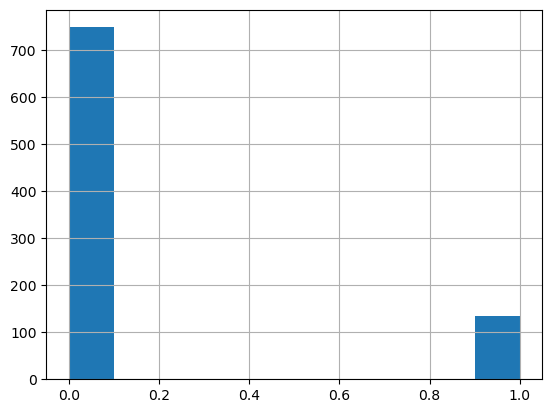

In [6]:
y_test.astype('int').hist()

In [37]:
data.isnull().sum()

Unnamed: 0.1                          0
Unnamed: 0                            0
Age                                   0
DistanceFromHome                      0
JobLevel                              0
MonthlyIncome                         0
NumCompaniesWorked                   19
PercentSalaryHike                     0
StockOptionLevel                      0
TotalWorkingYears                     9
TrainingTimesLastYear                 0
YearsAtCompany                        0
YearsSinceLastPromotion               0
YearsWithCurrManager                  0
MeanWorkingTime                       1
MedianWorkingTime                     1
SkewWorkingTime                       1
Attrition_Yes                         0
BusinessTravel_Travel_Frequently      0
BusinessTravel_Travel_Rarely          0
Department_Research & Development     0
Department_Sales                      0
Education_Below College               0
Education_College                     0
Education_Doctor                      0


In [38]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessing_pipeline = Pipeline(steps=[
    (
        'Fill missing values',
        SimpleImputer(strategy='median')  # can use median as there are no missing categorical features
    ),
    (
        'Scaling',
        StandardScaler()
    )
])

In [103]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(solver='liblinear')
grid_search_logreg = GridSearchCV(logreg, param_grid={
    'C': np.linspace(1e-6, 10, 100),
    'penalty': ['l1', 'l2']
})

In [104]:
grid_search_logreg = grid_search_logreg.fit(preprocessing_pipeline.fit_transform(x_train), y_train)

In [105]:
best_logreg = grid_search_logreg.best_estimator_

In [106]:
from plotly.express import area
from plotly.graph_objects import Figure
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve


def evaluate_classifier(clf) -> tuple[float, float, float, Figure]:
    x_test_ = preprocessing_pipeline.transform(x_test)
    labels = clf.predict(x_test_)
    probas = clf.predict_proba(x_test_)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, probas)
    

    figure = area(x=fpr, y=tpr, title=f'ROC curve of {str(type(clf)).split(".")[-1][:-2]}',
                  labels={'x': 'False Positive Rate', 'y': 'True Positive Rate'},
                  width=500, height=500)
    figure.add_shape(type='line', line={'dash': 'dash'}, x0=0, x1=1, y0=0, y1=1)
    return accuracy_score(y_test, labels), recall_score(y_test, labels), roc_auc_score(y_test, probas), figure


In [107]:
*logreg_scores, logreg_figure = evaluate_classifier(best_logreg)

In [1]:
import numpy as np

from pandas import DataFrame
from plotly.express import bar

bar(DataFrame({
    'x': x.columns,
    'y': np.abs(best_logreg.coef_.reshape(-1))
}), x='x', y='y')

NameError: name 'x' is not defined

In [109]:
for name, score in zip(['Accuracy', 'Recall', 'ROC AUC Score'], logreg_scores):
    print(f'{name}: {score}')

Accuracy: 0.8514739229024944
Recall: 0.11940298507462686
ROC AUC Score: 0.7478649533083246


In [110]:
logreg_figure.show()

In [112]:
import pickle

with open('../models/logreg.pkl', 'wb') as file:
    pickle.dump(grid_search_logreg.best_estimator_, file)